In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [10]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
# total/inclusive xsec model as function of gb, dbs, mass
# as shown in sec 9.3.1 of AN

import pickle
with open('fits/limit_setting/popt_c1.pkl', 'rb') as f:
    popt_c1 = pickle.load(f)
with open('fits/limit_setting/popt_k.pkl', 'rb') as f:
    popt_k = pickle.load(f)
    
popt_c1 = np.array([ 1.05310713e+05, -3.28074480e+00,  
                   2.12267138e+00, -3.10657155e-01,
                   2.07658838e-02,  0.00000000e+00,  
                   0.00000000e+00])
popt_k = np.array([1.34119984e-03, 4.07301911e+00])

def linear(x, c1, c2):
    return c1*x + c2

def exponet_500(x,c1,c2,c3,c4,c5,c6,c7):
    '''Custom fit function to fit the c1 as a function of mass curve'''
    x = x/500
    return np.exp(c2*x+c3*x**-1+c4*x**-2+c5*x**-3)*(c1)

def compute_c1(mass): return exponet_500(mass, *popt_c1)
def compute_k(mass): return linear(mass, *popt_k)

def total_xsec_func(mass, gb, dbs):
    '''Formula for xsec from gb, dbs'''
    c1 = compute_c1(mass)
    k = compute_k(mass)
    return c1 * gb**2 * (1 + k * dbs**2) 

# branching ratio for Z'->mumu

def branching_ratio_func(gb, gmu, dbs):
    '''Computes branching ratio from xsec dataframe.'''
    return 2/3*(1 + (gb/gmu)**2 * (1 + 2*dbs**2))**-1

In [45]:
def gmu_from_m_gb_dbs(mass, gb, dbs):
    '''calculate value of gmu based on eqn 5 in AN'''
    return 6.5e-06*(mass/100)**2/(gb*dbs)

In [46]:
#make a little class to simplify computing different properties for different paramter combinations
class ModelParams:
    def __init__(self, mass, gb, gmu, dbs):
        self.mass = mass
        self.dbs = dbs
        self.gb = gb
        # set gmu value to physical one based on gb, dbs, mass if not specified
        if gmu>0:
            self.gmu = gmu
        else:
            self.gmu = gmu_from_m_gb_dbs(mass, gb, dbs)

    def inclusive_xsec(self):
        return total_xsec_func(self.mass, self.gb, self.dbs)
    def mumu_br(self):
        return branching_ratio_func(self.gb, self.gmu, self.dbs)
    def mumu_xsec_from_br(self):
        return self.inclusive_xsec()*self.mumu_br()
    def is_valid(self):
        '''check if model params follow equation 5 of AN'''
        constant = self.gmu*self.dbs*self.gb*(100/self.mass)**2
        percent_off = (constant - 6.5e-06)/6.5e-06
        return percent_off < 1e-5

    def __repr__(self):
        text = '''mass: {} dbs: {:.2e} gb: {:.2e} gmu: {:.2e}
is valid: {} 
inc. xsec: {:.2e} [fb] mumu br: {:.2f}
mumu xsec: {:.2e} [fb]'''.format(
        self.mass, self.dbs, self.gb, self.gmu,
        self.is_valid(), self.inclusive_xsec(), self.mumu_br(),
        self.mumu_xsec_from_br())
        return text    

In [77]:
#test with example value: 
# 200 GeV dbs 0.5, gb .02, gmu .17,  mumu xsection = 5.926e-01  (pb) or 592.6 fb
# result is close (620 vs 592)
mass, gb, gmu, dbs  = 200, .02, .17, .5
model = ModelParams(mass, gb, gmu, dbs)

model

mass: 200 dbs: 5.00e-01 gb: 2.00e-02 gmu: 1.70e-01
is valid: False 
inc. xsec: 9.47e+02 [fb] mumu br: 0.65
mumu xsec: 6.18e+02 [fb]

In [109]:
# make grid of values for each gb and dbs point for a specific mass

def figures_of_merit(mass, gb, dbs, lumi): 

    mp = ModelParams(mass, gb, -1, dbs)
    #model acceptance as 10% without any further paramterization to simplify things for this demo
    #this is reasonable approx for SR2 at 200 GeV (my test point) as per figure 36 in AN
    acceptance = .025
    return {"acceptance": acceptance,
     "mumu_xsec": mp.mumu_xsec_from_br(),
     "mumu_br": mp.mumu_br(),
     "nevents": acceptance*lumi*mp.mumu_xsec_from_br(),
     "inclusive_xsec": mp.inclusive_xsec(),
     "gmu": mp.gmu,
    }
    
def make_gb_dbs_grid(mass, lumi,
                     gbs=np.linspace(1e-4, .02, 100),
                     dbses = np.linspace(1e-4, 1, 100)
                    ):

    return pd.DataFrame([{'gb':gb, 'dbs': dbs, **figures_of_merit(mass, gb, dbs, lumi)} for gb in gbs for dbs in dbses])
mass = 200

gbs_bins=np.linspace(0, .02, 100)
dbses_bins = np.linspace(0, 1, 100)
def calc_centers(arr):
    return [(arr[i] + arr[i+1])/2. for i in range(len(arr)-1)]
gbs_bin_centers = calc_centers(gbs_bins)
dbses_bins_centers = calc_centers(dbses_bins)
# combined 16-18 is about 140 fb  
lumi=140
gb_dbs_grid = make_gb_dbs_grid(mass, lumi, gbs=gbs_bin_centers, dbses=dbses_bins_centers)

In [110]:
def draw_2d_gb_dbs_plot(zaxis,
                        gbs=np.linspace(1e-4, .02, 100),
                        dbses = np.linspace(1e-4, 1, 100),
                        **kwargs
                       ):
    fig, ax = plt.subplots(1, figsize=(8,6))
    counts,ybins,xbins,image = ax.hist2d(gb_dbs_grid.gb, gb_dbs_grid.dbs, weights=gb_dbs_grid[zaxis], 
                                     bins = (gbs, dbses), 
                                    **kwargs)
    fig.colorbar(image, ax=ax)
    ax.set_ylabel('$\delta_{bs}$')
    ax.set_xlabel('$g_{b}$')
    ax.set_title(zaxis)
    return counts,ybins,xbins,image

In [111]:
##
## results
##

#finally, we look at the resulting distributions we see to see what our observed features are

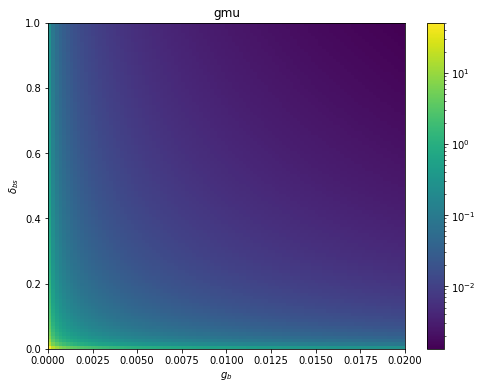

In [112]:
#as expected, gmu is largest near 0,0
_ = draw_2d_gb_dbs_plot('gmu', gbs=gbs_bins, dbses=dbses_bins, norm=LogNorm())

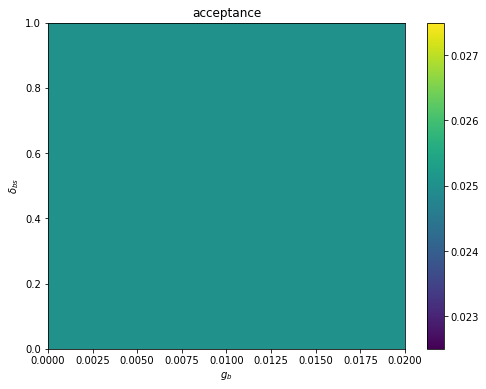

In [113]:
#acceptance in this case is just a flat 2.5%
_ = draw_2d_gb_dbs_plot('acceptance', gbs=gbs_bins, dbses=dbses_bins)

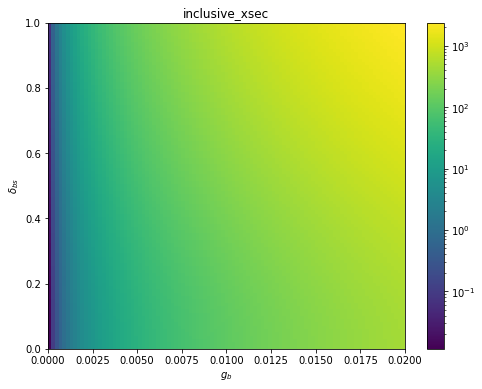

In [114]:
# this inclusive/total cross section peaks at the top right, typical values are ~10-1000 fbs
_ = draw_2d_gb_dbs_plot('inclusive_xsec', gbs=gbs_bins, dbses=dbses_bins, norm=LogNorm())

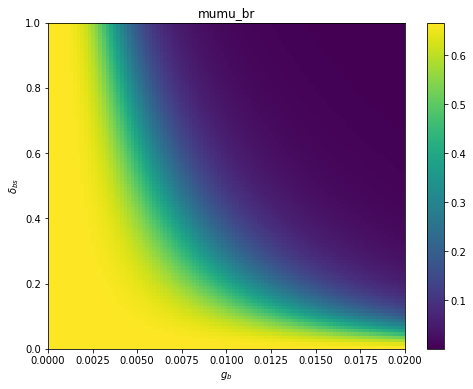

In [115]:
# The branching ration to mumu on the other hand peaks at the bottom left with a value of 2/3, top right falls quite dramatically due to low gmu
_ = draw_2d_gb_dbs_plot('mumu_br', gbs=gbs_bins, dbses=dbses_bins)

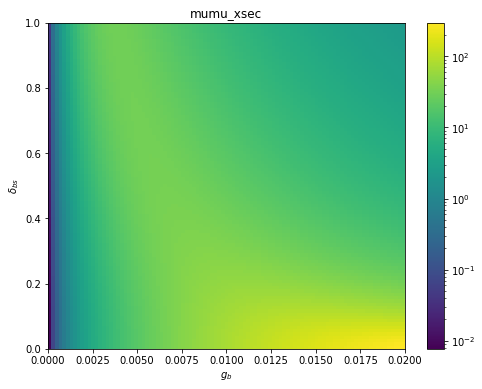

In [116]:
# The mumu cross section is a multiplication of the previous two histograms, and it features a band from the bottom right to the top left
# typical values are order 100 fb this seems to be reasonable considering our (unphysical) example is also of the order 100 fb
_ = draw_2d_gb_dbs_plot('mumu_xsec', gbs=gbs_bins, dbses=dbses_bins, norm=LogNorm())

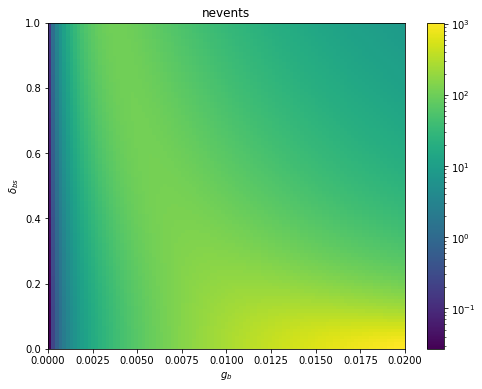

In [117]:
#finally, we can scale this by acceptance (10%) and lumi (140 fb) to predict an nevents by gb, dbs point
#we'll use the counts here to draw contours below
counts,ybins,xbins,image = draw_2d_gb_dbs_plot('nevents', gbs=gbs_bins, dbses=dbses_bins, norm=LogNorm())

In [118]:
##
## drawing a limit line 
##

In [121]:
# now, lets draw realistic limit curves:
# we exclude:
#200 gev SR2 2016: 38 events

In [122]:
def draw_lim_curve(limit, counts):
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.contour(counts.T,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=3, 
           levels=[limit])
    ax.set_ylabel('$\delta_{bs}$')
    ax.set_xlabel('$g_{b}$')


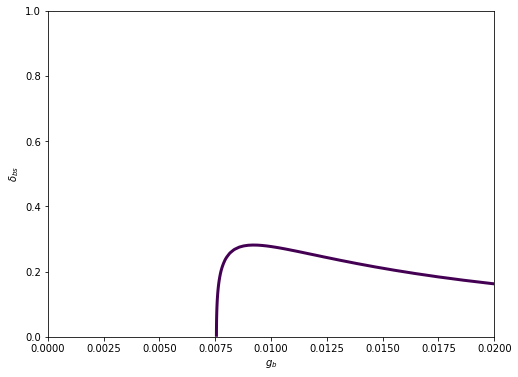

In [123]:
#scale down for 2016 lumi
counts_2016 = counts/lumi*35
draw_lim_curve(38, counts_2016)